# Method 5 - Best Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
# Backtest the Portfolio

w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

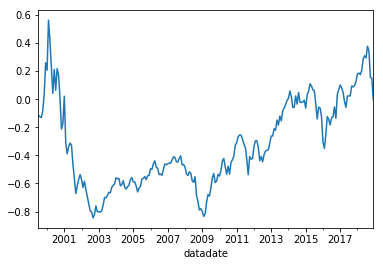

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.259695
2000-12-31   -0.344447
2001-12-31   -0.439084
2002-12-31   -0.572458
2003-12-31    1.007277
2004-12-31    0.112449
2005-12-31    0.033225
2006-12-31    0.166791
2007-12-31    0.003061
2008-12-31   -0.587092
2009-12-31    1.106356
2010-12-31    0.447014
2011-12-31   -0.143262
2012-12-31    0.195692
2013-12-31    0.437184
2014-12-31    0.001722
2015-12-31   -0.116881
2016-12-31    0.218215
2017-12-31    0.054794
2018-12-31   -0.114829
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     316.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.38e-92
Time:                        05:29:29   Log-Likelihood:                 410.89
No. Observations:                 234   AIC:                            -811.8
Df Residuals:                     229   BIC:                            -794.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.605      0.546      -0.004       0.007
mktrf          1.4489      0.079     18.386      0.000       1.294       1.604
me             0.6671      0.092      7.277      0.000       0.486       0.848
ia            -0.1875      0.139     -1.346      0.180      -0.462       0.087
roe           -1.1153      0.119     -9.352      0.000      -1.350      -0.880
==============================================================================
Omnibus:                       52.579   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.947
Skew:                           0.809   Prob(JB):                     5.24e-50
Kurtosis:                       7.545   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     167.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.08e-66
Time:                        05:29:29   Log-Likelihood:                 410.89
No. Observations:                 234   AIC:                            -811.8
Df Residuals:                     229   BIC:                            -794.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.639      0.523      -0.004       0.007
mktrf          1.4489      0.119     12.200      0.000       1.216       1.682
me             0.6671      0.103      6.457      0.000       0.465       0.870
ia            -0.1875      0.208     -0.900      0.368      -0.596       0.221
roe           -1.1153      0.226     -4.942      0.000      -1.558      -0.673
==============================================================================
Omnibus:                       52.579   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.947
Skew:                           0.809   Prob(JB):                     5.24e-50
Kurtosis:                       7.545   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     201.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.06e-73
Time:                        05:29:29   Log-Likelihood:                 410.89
No. Observations:                 234   AIC:                            -811.8
Df Residuals:                     229   BIC:                            -794.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.635      0.526      -0.004       0.007
mktrf          1.4489      0.129     11.271      0.000       1.197       1.701
me             0.6671      0.112      5.970      0.000       0.448       0.886
ia            -0.1875      0.186     -1.009      0.313      -0.552       0.177
roe           -1.1153      0.231     -4.819      0.000      -1.569      -0.662
==============================================================================
Omnibus:                       52.579   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.947
Skew:                           0.809   Prob(JB):                     5.24e-50
Kurtosis:                       7.545   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     238.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.28e-88
Time:                        05:29:29   Log-Likelihood:                 405.11
No. Observations:                 234   AIC:                            -798.2
Df Residuals:                     228   BIC:                            -777.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.564      0.573      -0.004       0.008
mktrf          1.5278      0.081     18.836      0.000       1.368       1.688
smb            0.6484      0.107      6.059      0.000       0.438       0.859
hml            0.1786      0.126      1.415      0.158      -0.070       0.427
rmw           -1.1472      0.143     -8.040      0.000      -1.428      -0.866
cma           -0.0987      0.181     -0.544      0.587      -0.456       0.259
==============================================================================
Omnibus:                       77.869   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.457
Skew:                           1.284   Prob(JB):                     2.88e-72
Kurtosis:                       8.215   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     135.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.89e-66
Time:                        05:29:29   Log-Likelihood:                 405.11
No. Observations:                 234   AIC:                            -798.2
Df Residuals:                     228   BIC:                            -777.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.697      0.486      -0.003       0.006
mktrf          1.5278      0.086     17.723      0.000       1.359       1.697
smb            0.6484      0.117      5.519      0.000       0.418       0.879
hml            0.1786      0.229      0.779      0.436      -0.271       0.628
rmw           -1.1472      0.197     -5.821      0.000      -1.533      -0.761
cma           -0.0987      0.296     -0.334      0.739      -0.678       0.481
==============================================================================
Omnibus:                       77.869   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.457
Skew:                           1.284   Prob(JB):                     2.88e-72
Kurtosis:                       8.215   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     151.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.02e-70
Time:                        05:29:29   Log-Likelihood:                 405.11
No. Observations:                 234   AIC:                            -798.2
Df Residuals:                     228   BIC:                            -777.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.681      0.496      -0.003       0.007
mktrf          1.5278      0.081     18.908      0.000       1.369       1.686
smb            0.6484      0.118      5.495      0.000       0.417       0.880
hml            0.1786      0.195      0.918      0.359      -0.203       0.560
rmw           -1.1472      0.204     -5.621      0.000      -1.547      -0.747
cma           -0.0987      0.265     -0.373      0.710      -0.618       0.420
==============================================================================
Omnibus:                       77.869   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.457
Skew:                           1.284   Prob(JB):                     2.88e-72
Kurtosis:                       8.215   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     286.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.23e-88
Time:                        05:29:29   Log-Likelihood:                 400.95
No. Observations:                 234   AIC:                            -791.9
Df Residuals:                     229   BIC:                            -774.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.003     -0.646      0.519      -0.008       0.004
mktrf          1.6199      0.076     21.398      0.000       1.471       1.769
smb            1.1677      0.094     12.357      0.000       0.982       1.354
hml           -0.1537      0.094     -1.637      0.103      -0.339       0.031
umd           -0.4422      0.062     -7.180      0.000      -0.564      -0.321
==============================================================================
Omnibus:                       35.029   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.573
Skew:                           0.686   Prob(JB):                     7.12e-19
Kurtosis:                       5.586   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     202.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.08e-74
Time:                        05:29:29   Log-Likelihood:                 400.95
No. Observations:                 234   AIC:                            -791.9
Df Residuals:                     229   BIC:                            -774.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.003     -0.732      0.464      -0.007       0.003
mktrf          1.6199      0.090     18.065      0.000       1.444       1.796
smb            1.1677      0.087     13.435      0.000       0.997       1.338
hml           -0.1537      0.142     -1.083      0.279      -0.432       0.124
umd           -0.4422      0.104     -4.262      0.000      -0.646      -0.239
==============================================================================
Omnibus:                       35.029   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.573
Skew:                           0.686   Prob(JB):                     7.12e-19
Kurtosis:                       5.586   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     221.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.02e-77
Time:                        05:29:29   Log-Likelihood:                 400.95
No. Observations:                 234   AIC:                            -791.9
Df Residuals:                     229   BIC:                            -774.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.003     -0.737      0.461      -0.007       0.003
mktrf          1.6199      0.095     17.069      0.000       1.434       1.806
smb            1.1677      0.082     14.164      0.000       1.006       1.329
hml           -0.1537      0.133     -1.155      0.248      -0.414       0.107
umd           -0.4422      0.103     -4.279      0.000      -0.645      -0.240
==============================================================================
Omnibus:                       35.029   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.573
Skew:                           0.686   Prob(JB):                     7.12e-19
Kurtosis:                       5.586   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     153.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.13e-45
Time:                        05:29:29   Log-Likelihood:                 190.07
No. Observations:                 120   AIC:                            -370.1
Df Residuals:                     115   BIC:                            -356.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.005      0.709      0.479      -0.006       0.013
mktrf          1.4309      0.131     10.946      0.000       1.172       1.690
me             0.5756      0.129      4.458      0.000       0.320       0.831
ia            -0.2998      0.202     -1.483      0.141      -0.700       0.101
roe           -1.0921      0.179     -6.103      0.000      -1.447      -0.738
==============================================================================
Omnibus:                       23.340   Durbin-Watson:                   2.318
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.205
Skew:                           0.700   Prob(JB):                     1.39e-13
Kurtosis:                       6.143   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     148.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.69e-44
Time:                        05:29:29   Log-Likelihood:                 190.07
No. Observations:                 120   AIC:                            -370.1
Df Residuals:                     115   BIC:                            -356.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.005      0.764      0.445      -0.005       0.012
mktrf          1.4309      0.174      8.210      0.000       1.089       1.772
me             0.5756      0.135      4.261      0.000       0.311       0.840
ia            -0.2998      0.292     -1.028      0.304      -0.871       0.272
roe           -1.0921      0.300     -3.641      0.000      -1.680      -0.504
==============================================================================
Omnibus:                       23.340   Durbin-Watson:                   2.318
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.205
Skew:                           0.700   Prob(JB):                     1.39e-13
Kurtosis:                       6.143   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     203.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.27e-51
Time:                        05:29:29   Log-Likelihood:                 190.07
No. Observations:                 120   AIC:                            -370.1
Df Residuals:                     115   BIC:                            -356.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.004      0.803      0.422      -0.005       0.012
mktrf          1.4309      0.190      7.548      0.000       1.059       1.802
me             0.5756      0.144      4.001      0.000       0.294       0.858
ia            -0.2998      0.259     -1.160      0.246      -0.807       0.207
roe           -1.0921      0.315     -3.465      0.001      -1.710      -0.474
==============================================================================
Omnibus:                       23.340   Durbin-Watson:                   2.318
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.205
Skew:                           0.700   Prob(JB):                     1.39e-13
Kurtosis:                       6.143   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     116.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.36e-43
Time:                        05:29:29   Log-Likelihood:                 187.87
No. Observations:                 120   AIC:                            -363.7
Df Residuals:                     114   BIC:                            -347.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.005      0.915      0.362      -0.005       0.015
mktrf          1.6520      0.141     11.717      0.000       1.373       1.931
smb            0.6117      0.160      3.830      0.000       0.295       0.928
hml           -0.1051      0.196     -0.537      0.592      -0.493       0.283
rmw           -0.8916      0.231     -3.864      0.000      -1.349      -0.435
cma            0.0124      0.253      0.049      0.961      -0.488       0.513
==============================================================================
Omnibus:                       46.814   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.564
Skew:                           1.438   Prob(JB):                     1.34e-30
Kurtosis:                       7.386   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     62.17
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.74e-31
Time:                        05:29:29   Log-Likelihood:                 187.87
No. Observations:                 120   AIC:                            -363.7
Df Residuals:                     114   BIC:                            -347.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.004      1.322      0.186      -0.002       0.012
mktrf          1.6520      0.153     10.831      0.000       1.353       1.951
smb            0.6117      0.157      3.908      0.000       0.305       0.918
hml           -0.1051      0.226     -0.466      0.642      -0.547       0.337
rmw           -0.8916      0.249     -3.575      0.000      -1.381      -0.403
cma            0.0124      0.350      0.036      0.972      -0.673       0.698
==============================================================================
Omnibus:                       46.814   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.564
Skew:                           1.438   Prob(JB):                     1.34e-30
Kurtosis:                       7.386   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     70.54
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.84e-33
Time:                        05:29:29   Log-Likelihood:                 187.87
No. Observations:                 120   AIC:                            -363.7
Df Residuals:                     114   BIC:                            -347.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.003      1.509      0.131      -0.001       0.011
mktrf          1.6520      0.135     12.276      0.000       1.388       1.916
smb            0.6117      0.152      4.018      0.000       0.313       0.910
hml           -0.1051      0.198     -0.531      0.595      -0.493       0.282
rmw           -0.8916      0.268     -3.322      0.001      -1.418      -0.366
cma            0.0124      0.304      0.041      0.967      -0.583       0.608
==============================================================================
Omnibus:                       46.814   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.564
Skew:                           1.438   Prob(JB):                     1.34e-30
Kurtosis:                       7.386   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     163.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.81e-46
Time:                        05:29:29   Log-Likelihood:                 193.34
No. Observations:                 120   AIC:                            -376.7
Df Residuals:                     115   BIC:                            -362.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.005      0.192      0.848      -0.008       0.010
mktrf          1.6734      0.112     14.933      0.000       1.451       1.895
smb            1.0947      0.128      8.580      0.000       0.842       1.347
hml           -0.3458      0.128     -2.706      0.008      -0.599      -0.093
umd           -0.4205      0.079     -5.337      0.000      -0.577      -0.264
==============================================================================
Omnibus:                       22.254   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.118
Skew:                           0.786   Prob(JB):                     7.15e-10
Kurtosis:                       5.440   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.23e-46
Time:                        05:29:29   Log-Likelihood:                 193.34
No. Observations:                 120   AIC:                            -376.7
Df Residuals:                     115   BIC:                            -362.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.004      0.231      0.817      -0.007       0.008
mktrf          1.6734      0.127     13.129      0.000       1.424       1.923
smb            1.0947      0.095     11.504      0.000       0.908       1.281
hml           -0.3458      0.168     -2.061      0.039      -0.675      -0.017
umd           -0.4205      0.111     -3.773      0.000      -0.639      -0.202
==============================================================================
Omnibus:                       22.254   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.118
Skew:                           0.786   Prob(JB):                     7.15e-10
Kurtosis:                       5.440   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     211.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.41e-52
Time:                        05:29:29   Log-Likelihood:                 193.34
No. Observations:                 120   AIC:                            -376.7
Df Residuals:                     115   BIC:                            -362.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.004      0.246      0.806      -0.006       0.008
mktrf          1.6734      0.136     12.326      0.000       1.407       1.939
smb            1.0947      0.086     12.758      0.000       0.927       1.263
hml           -0.3458      0.159     -2.172      0.030      -0.658      -0.034
umd           -0.4205      0.113     -3.724      0.000      -0.642      -0.199
==============================================================================
Omnibus:                       22.254   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.118
Skew:                           0.786   Prob(JB):                     7.15e-10
Kurtosis:                       5.440   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     176.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.04e-46
Time:                        05:29:29   Log-Likelihood:                 236.73
No. Observations:                 114   AIC:                            -463.5
Df Residuals:                     109   BIC:                            -449.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.383      0.703      -0.005       0.007
mktrf          1.4103      0.091     15.464      0.000       1.230       1.591
me             0.9162      0.141      6.507      0.000       0.637       1.195
ia            -0.0235      0.195     -0.120      0.905      -0.411       0.364
roe           -1.2072      0.172     -7.034      0.000      -1.547      -0.867
==============================================================================
Omnibus:                       10.996   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.001
Skew:                           0.569   Prob(JB):                      0.00150
Kurtosis:                       4.201   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     127.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.24e-40
Time:                        05:29:29   Log-Likelihood:                 236.73
No. Observations:                 114   AIC:                            -463.5
Df Residuals:                     109   BIC:                            -449.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.546      0.585      -0.003       0.005
mktrf          1.4103      0.122     11.531      0.000       1.171       1.650
me             0.9162      0.188      4.879      0.000       0.548       1.284
ia            -0.0235      0.229     -0.103      0.918      -0.472       0.425
roe           -1.2072      0.245     -4.918      0.000      -1.688      -0.726
==============================================================================
Omnibus:                       10.996   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.001
Skew:                           0.569   Prob(JB):                      0.00150
Kurtosis:                       4.201   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     135.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.02e-41
Time:                        05:29:29   Log-Likelihood:                 236.73
No. Observations:                 114   AIC:                            -463.5
Df Residuals:                     109   BIC:                            -449.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.547      0.584      -0.003       0.005
mktrf          1.4103      0.126     11.158      0.000       1.163       1.658
me             0.9162      0.213      4.307      0.000       0.499       1.333
ia            -0.0235      0.233     -0.101      0.920      -0.480       0.433
roe           -1.2072      0.248     -4.873      0.000      -1.693      -0.722
==============================================================================
Omnibus:                       10.996   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.001
Skew:                           0.569   Prob(JB):                      0.00150
Kurtosis:                       4.201   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     143.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.65e-46
Time:                        05:29:29   Log-Likelihood:                 237.75
No. Observations:                 114   AIC:                            -463.5
Df Residuals:                     108   BIC:                            -447.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.107      0.915      -0.006       0.006
mktrf          1.4408      0.087     16.637      0.000       1.269       1.612
smb            0.7650      0.141      5.441      0.000       0.486       1.044
hml            0.4966      0.179      2.770      0.007       0.141       0.852
rmw           -1.4073      0.220     -6.410      0.000      -1.842      -0.972
cma           -0.2554      0.279     -0.916      0.362      -0.808       0.297
==============================================================================
Omnibus:                        1.622   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.117
Skew:                           0.190   Prob(JB):                        0.572
Kurtosis:                       3.300   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     101.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.27e-39
Time:                        05:29:29   Log-Likelihood:                 237.75
No. Observations:                 114   AIC:                            -463.5
Df Residuals:                     108   BIC:                            -447.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.113      0.910      -0.006       0.005
mktrf          1.4408      0.086     16.849      0.000       1.273       1.608
smb            0.7650      0.145      5.275      0.000       0.481       1.049
hml            0.4966      0.169      2.936      0.003       0.165       0.828
rmw           -1.4073      0.207     -6.792      0.000      -1.813      -1.001
cma           -0.2554      0.279     -0.915      0.360      -0.802       0.292
==============================================================================
Omnibus:                        1.622   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.117
Skew:                           0.190   Prob(JB):                        0.572
Kurtosis:                       3.300   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     109.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.28e-40
Time:                        05:29:29   Log-Likelihood:                 237.75
No. Observations:                 114   AIC:                            -463.5
Df Residuals:                     108   BIC:                            -447.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.105      0.916      -0.006       0.006
mktrf          1.4408      0.089     16.179      0.000       1.266       1.615
smb            0.7650      0.161      4.740      0.000       0.449       1.081
hml            0.4966      0.137      3.629      0.000       0.228       0.765
rmw           -1.4073      0.189     -7.454      0.000      -1.777      -1.037
cma           -0.2554      0.292     -0.874      0.382      -0.828       0.317
==============================================================================
Omnibus:                        1.622   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.117
Skew:                           0.190   Prob(JB):                        0.572
Kurtosis:                       3.300   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     128.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.39e-40
Time:                        05:29:29   Log-Likelihood:                 221.37
No. Observations:                 114   AIC:                            -432.7
Df Residuals:                     109   BIC:                            -419.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.004     -0.648      0.518      -0.009       0.005
mktrf          1.5110      0.099     15.279      0.000       1.315       1.707
smb            1.0812      0.154      7.012      0.000       0.776       1.387
hml            0.4565      0.159      2.875      0.005       0.142       0.771
umd           -0.3392      0.120     -2.831      0.006      -0.577      -0.102
==============================================================================
Omnibus:                        6.169   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.807
Skew:                           0.337   Prob(JB):                       0.0332
Kurtosis:                       3.989   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     132.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.49e-41
Time:                        05:29:29   Log-Likelihood:                 221.37
No. Observations:                 114   AIC:                            -432.7
Df Residuals:                     109   BIC:                            -419.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.003     -0.792      0.428      -0.008       0.003
mktrf          1.5110      0.104     14.477      0.000       1.306       1.716
smb            1.0812      0.157      6.904      0.000       0.774       1.388
hml            0.4565      0.188      2.424      0.015       0.087       0.826
umd           -0.3392      0.126     -2.689      0.007      -0.586      -0.092
==============================================================================
Omnibus:                        6.169   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.807
Skew:                           0.337   Prob(JB):                       0.0332
Kurtosis:                       3.989   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     169.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.31e-46
Time:                        05:29:29   Log-Likelihood:                 221.37
No. Observations:                 114   AIC:                            -432.7
Df Residuals:                     109   BIC:                            -419.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.003     -0.809      0.418      -0.008       0.003
mktrf          1.5110      0.107     14.152      0.000       1.302       1.720
smb            1.0812      0.147      7.332      0.000       0.792       1.370
hml            0.4565      0.172      2.655      0.008       0.120       0.794
umd           -0.3392      0.130     -2.601      0.009      -0.595      -0.084
==============================================================================
Omnibus:                        6.169   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.807
Skew:                           0.337   Prob(JB):                       0.0332
Kurtosis:                       3.989   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""